In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import shape, spectral
from scipy import stats, signal
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# Simulate trial data with 3 conditions

In [2]:
# Define general simulation parameters
np.random.seed(0)
N_trials = 100
Fs = 1000
f_range = (8,12)
freq = 10

tlims = (-1, 2)
T_full = tlims[1] - tlims[0]
T_burst = tlims[1]

f_hipass_brown = 2
hipass_N = int(3 * Fs / f_hipass_brown)
if hipass_N % 2 == 0:
    hipass_N += 1
t = np.arange(tlims[0], tlims[1], 1/Fs)

# Define simulation parameters
conditions = ['baseline', 'longer bursts', 'higher amp']
amps = {'baseline': 1, 'longer bursts': 1, 'higher amp': 1.2}
prob_leave_bursts = {'baseline': .2, 'longer bursts': .1, 'higher amp': .2}
prob_enter_bursts = {'baseline': .2, 'longer bursts': .3, 'higher amp': .2}

# For each condition
xs = defaultdict(list)
dfs = defaultdict(list)
for c in conditions:
    cycle_features = {'amp_mean': amps[c], 'amp_burst_std': 0, 'amp_std': 0,
                      'period_mean': int(Fs / freq), 'period_burst_std': 0, 'period_std': 0,
                      'rdsym_mean': .5, 'rdsym_burst_std': 0, 'rdsym_std': 0}
    
    for tr in range(N_trials):
        # Simulate noise
        brown = neurodsp.sim_filtered_brown_noise(T_full, Fs, (f_hipass_brown, None), hipass_N)
        
        # Generate oscillator after time zero
        oscillator, df = neurodsp.sim_bursty_oscillator(freq, T_burst, Fs,
                                                        prob_enter_burst=prob_enter_bursts[c],
                                                        prob_leave_burst=prob_leave_bursts[c],
                                                        cycle_features=cycle_features,
                                                        return_cycle_df=True)
        
        # Add oscillator after time zero
        x = np.copy(brown*.5)
        x[-len(oscillator):] += 10*oscillator
        xs[c].append(x)
        dfs[c].append(df)

# A. Average event-related amplitudes for 3 simulated conditions

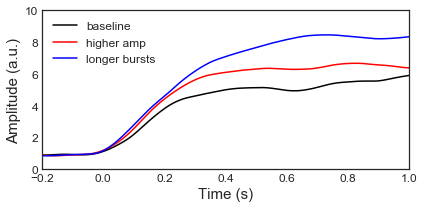

In [3]:
# Compute average instantaneous amplitude
amps = defaultdict(list)
mean_amp_ts = defaultdict()
for c in conditions:
    for tr in range(N_trials):
        amps[c].append(neurodsp.amp_by_time(xs[c][tr], Fs, f_range))
    mean_amp_ts[c] = np.mean(np.array(amps[c]), axis=0)

plt.figure(figsize=(6,3))
conditions = ['baseline', 'higher amp', 'longer bursts']
colors = ['k', 'r', 'b']
for i, c in enumerate(conditions):
    plt.plot(t, mean_amp_ts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((0,10))
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time (s)', size=15)
plt.ylabel('Amplitude (a.u.)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.tight_layout()
plt.savefig('figs/5A_inst_amp_ts')

# Compute cycle by cycle features

In [4]:
# Define event-related bins
bin_edges = np.arange(-.5, 1.1, .1)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

# Define oscillation definition parameters
osc_kws = {'amplitude_fraction_threshold': 0,
           'amplitude_consistency_threshold': .6,
           'period_consistency_threshold': .75,
           'monotonicity_threshold': .8,
           'N_cycles_min': 3}

# Apply 1-50Hz bandpass filter
f_bandpass = (1, 50)
filter_seconds = (2, .2)

xs_broad = defaultdict(list)
binned_amps = defaultdict()
binned_bursts = defaultdict()
dfs_shape = defaultdict(list)
for c in conditions:
    for tr in range(N_trials):
        # Do broad bandpass of signal
        x_broad = neurodsp.filter(xs[c][tr], Fs, 'highpass', f_hi=f_bandpass[0],
                                  N_seconds=filter_seconds[0],
                                  remove_edge_artifacts=False)
        x_broad = neurodsp.filter(x_broad, Fs, 'lowpass', f_lo=f_bandpass[1],
                                  N_seconds=filter_seconds[1],
                                  remove_edge_artifacts=False)
        xs_broad[c].append(x_broad)
        
        df_shape = shape.features_by_cycle(x_broad, Fs, f_range, center_extrema='T',
                                           estimate_oscillating_periods=True,
                                           estimate_oscillating_periods_kwargs=osc_kws)
        df_shape['trial'] = tr
        
        # divide by 2 because amp is peak-to-trough whereas instamp is zero-to-peak
        df_shape['volt_amp'] = df_shape['volt_amp'] / 2
        dfs_shape[c].append(df_shape)
        
    # Aggregate all trials
    df_shape_cond = pd.concat(dfs_shape[c]).reset_index(drop=True)[['sample_trough', 'volt_amp', 'is_cycle']]
    # Compute time from sample
    df_shape_cond['t'] = t[df_shape_cond['sample_trough'].values]
    # Bin time
    df_shape_cond['t_bin'] = pd.cut(df_shape_cond['t'], bin_edges)
    
    # Compute bursting and amp in each time bin
    df_burst_by_t = df_shape_cond.groupby('t_bin')['is_cycle'].mean()
    df_amp_by_t = df_shape_cond[df_shape_cond['is_cycle']].groupby('t_bin')['volt_amp'].mean()
    binned_amps[c] = df_amp_by_t.values
    binned_bursts[c] = df_burst_by_t.values

/gh/bv/neurodsp/neurodsp/filt.py:78: UserWarning: "f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.
  warnings.warn('"f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.')
/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/gh/bv/neurodsp/neurodsp/filt.py:78: UserWarning: "f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.
  warnings.warn('"f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.')
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid valu

# B. Average event-related cycle-by-cycle amplitudes

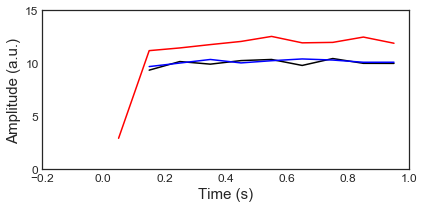

In [5]:
plt.figure(figsize=(6,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_amps[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((0,15))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Amplitude (a.u.)', size=15)
plt.xticks(size=12)
plt.yticks(np.arange(0,20,5), size=12)

plt.tight_layout()
plt.savefig('figs/5B_cycle_amp_ts')

# C. Average event-related bursting

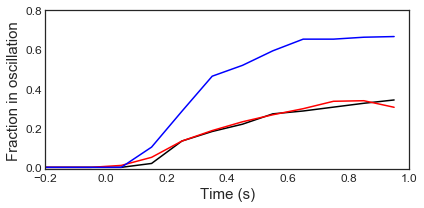

In [6]:
plt.figure(figsize=(6,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_bursts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((-.01,.8))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Fraction in oscillation', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.tight_layout()
plt.savefig('figs/5C_cycle_burst_ts')

# D. Distributions of trial instantaneous amplitudes

MannwhitneyuResult(statistic=4232.0, pvalue=0.030375664940712636)


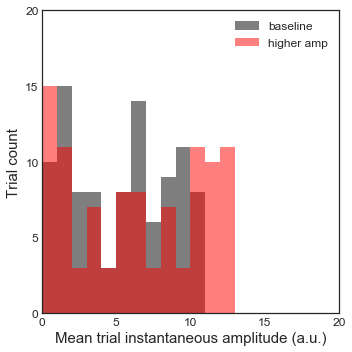

In [7]:
# Compute mean instantaneous amplitude 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
inst_amp_trial_means = {}
for c in conditions:
    inst_amp_trial_means[c] = np.mean(np.array([x[tidxs] for x in amps[c]]), axis=1)
print(stats.mannwhitneyu(inst_amp_trial_means['baseline'], inst_amp_trial_means['higher amp']))

# Histogram of mean instantaneous amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
colors = ['k', 'r']
for i, c in enumerate(['baseline', 'higher amp']):
    plt.hist(inst_amp_trial_means[c], bins=np.arange(0,20, 1), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 20))
plt.ylim((0, 20))
plt.legend(loc='best', fontsize=12)
plt.ylabel('Trial count', size=15)
plt.xlabel('Mean trial instantaneous amplitude (a.u.)', size=15)
plt.xticks(np.arange(0, 25, 5), size=12)
plt.yticks(np.arange(0, 25, 5), size=12)

plt.tight_layout()
plt.savefig('figs/5D_inst_amp_dist')

# E. Distributions of trial cycle amplitudes

MannwhitneyuResult(statistic=123.0, pvalue=9.665537599114034e-14)


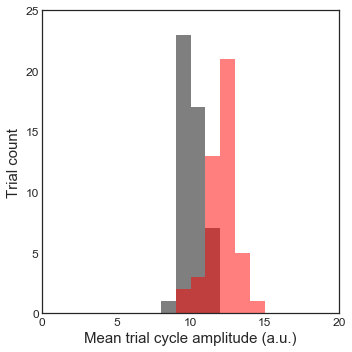

In [8]:
# Compute mean cycle amplitude 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
cycle_amp_trial_means = {}
for c in conditions:
    # Get dataframe of interest
    df_temp = pd.concat(dfs_shape[c])
    df_temp = df_temp[df_temp['is_cycle']]
    df_temp['t'] = t[df_temp['sample_trough'].values]
    df_temp = df_temp[(df_temp['t']>=tlim[0]) & (df_temp['t']<tlim[1])]
    cycle_amp_trial_means[c] = df_temp.groupby('trial')['volt_amp'].mean()
print(stats.mannwhitneyu(cycle_amp_trial_means['baseline'], cycle_amp_trial_means['higher amp']))

# Histogram of mean cycle amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
for i, c in enumerate(['baseline', 'higher amp']):
    plt.hist(cycle_amp_trial_means[c], bins=np.arange(0, 20, 1), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 20))
plt.ylim((0, 25))
plt.ylabel('Trial count', size=15)
plt.xlabel('Mean trial cycle amplitude (a.u.)', size=15)
plt.xticks(np.arange(0, 25, 5), size=12)
plt.yticks(np.arange(0, 30, 5), size=12)

plt.tight_layout()
plt.savefig('figs/5E_cycle_amp_dist')

# REVISION. Visualize single trials for each condition

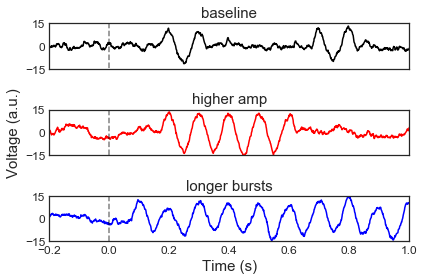

In [9]:
conditions = ['baseline', 'higher amp', 'longer bursts']
colors = ['k', 'r', 'b']

trial_plot = {'baseline': 0, 'higher amp': 1, 'longer bursts': 0}
plt.figure(figsize=(6,4))
for i, (k, color) in enumerate(zip(conditions, colors)):
    plt.subplot(3, 1, i+1)
    plt.plot(t, xs[k][trial_plot[k]], color=color)
    plt.plot([0,0], [-20, 20], 'k--', alpha=.5)
    plt.title(k, size=15)
    plt.xlim((-.2, 1))
    plt.ylim((-15, 15))
    plt.yticks([-15, 0, 15], size=12)
    
    if i == len(conditions) - 1:
        plt.xticks(size=12)
    elif i == 1:
        plt.ylabel('Voltage (a.u.)', size=15)
        plt.xticks([])
    else:
        plt.xticks([])
plt.xlabel('Time (s)', size=15)

plt.tight_layout()
plt.savefig('figs/5A_condition_timeseries')

### example trial amplitude profiles

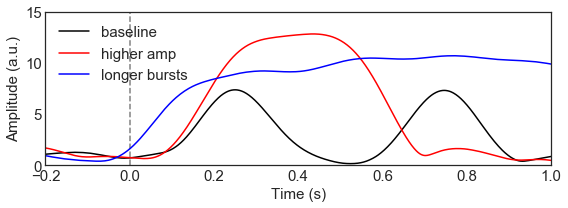

In [10]:
plt.figure(figsize=(8,3))
plt.plot([0,0], [0, 15], 'k--', alpha=.5)
for i, (k, color) in enumerate(zip(conditions, colors)):
    plt.plot(t, amps[k][trial_plot[k]], color=color, label=k)
    plt.xlim((-.2, 1))
    plt.ylim((0, 15))
    plt.yticks(np.arange(0,20,5), size=15)
plt.xticks(size=15)
plt.legend(fontsize=15)
plt.xlabel('Time (s)', size=15)
plt.ylabel('Amplitude (a.u.)', size=15)
plt.tight_layout()

# REVISION. Burst detection partially rescues Hilbert performance
* Still not as good because differentiates amp between baseline and longer bursts

cycle MannwhitneyuResult(statistic=123.0, pvalue=9.665537599114034e-14)
burst detect + hilbert MannwhitneyuResult(statistic=1963.0, pvalue=7.949463808131173e-06)
hilbert MannwhitneyuResult(statistic=4232.0, pvalue=0.030375664940712636)


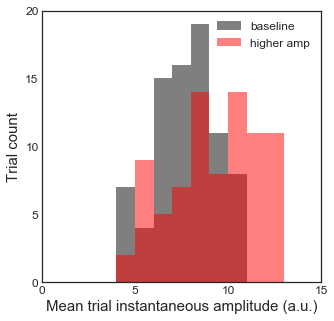

In [11]:
# Detect bursting in each trial, and compute mean amplitude 500-1000ms
from neurodsp import burst
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])

# Compute median inst amp
amp_concat = []
for c in conditions:
    amp_concat.append(np.concatenate(amps[c]))
amp_concat = np.concatenate(amp_concat)
median_amp = np.median(amp_concat)

# Determine amplitude of only oscillating periods for each trial
burst_amp_mean = defaultdict(list)
burst_frac = defaultdict(list)
for c in conditions:
    for tr in range(N_trials):
        # Burst detection
        amp_temp = amps[c][tr][tidxs]
        isosc = burst._2threshold_split(amp_temp, median_amp*3, median_amp*1.5)
        
        # Optionally plot the burst detection
        if False:
            if tr == 9:
                plt.figure()
                plt.plot(xs[c][tr][tidxs])
                plt.plot(amp_temp/median_amp)
                plt.plot(isosc)
    
        # Compute mean amplitude in time period of interest
        burst_frac[c].append(np.mean(isosc))
        if np.sum(isosc) > 0:
            burst_amp_mean[c].append(np.mean(amp_temp[isosc.astype(bool)]))
        else:
            burst_amp_mean[c].append(np.nan)
    
    # Drop nans
    burst_amp_mean[c] = np.array(burst_amp_mean[c])[~np.isnan(burst_amp_mean[c])]

print('cycle', stats.mannwhitneyu(cycle_amp_trial_means['baseline'], cycle_amp_trial_means['higher amp']))
print('burst detect + hilbert', stats.mannwhitneyu(burst_amp_mean['baseline'], burst_amp_mean['higher amp']))
print('hilbert', stats.mannwhitneyu(inst_amp_trial_means['baseline'], inst_amp_trial_means['higher amp']))

# Histogram of mean instantaneous amplitudes to see trial differentiation
plt.figure(figsize=(5,5))
colors = ['k', 'r']
for i, c in enumerate(['baseline', 'higher amp']):
    plt.hist(burst_amp_mean[c], bins=np.arange(0,15, 1), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 15))
plt.ylim((0, 20))
plt.legend(loc='best', fontsize=12)
plt.ylabel('Trial count', size=15)
plt.xlabel('Mean trial instantaneous amplitude (a.u.)', size=15)
plt.xticks(np.arange(0, 20, 5), size=12)
plt.yticks(np.arange(0, 25, 5), size=12);

### Fraction of time in burst (Feingold burst detection)

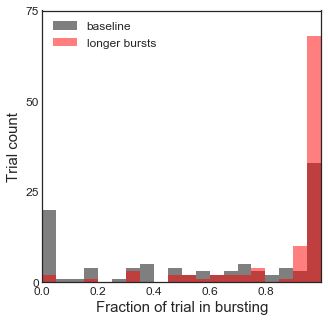

In [15]:
plt.figure(figsize=(5,5))
colors = ['k', 'r']
for i, c in enumerate(['baseline', 'longer bursts']):
    plt.hist(burst_frac[c], bins=np.arange(0,1.05,.05), label=c, alpha=.5, color=colors[i])

plt.xlim((0, 1))
plt.ylim((0, 75))
plt.legend(loc='best', fontsize=12)
plt.ylabel('Trial count', size=15)
plt.xlabel('Fraction of trial in bursting', size=15)
plt.xticks(np.arange(0, 1, .2), size=12)
plt.yticks(np.arange(0, 80, 25), size=12);

### Compare algorithms: baseline vs. longer burst difference in amp

In [16]:
print(stats.mannwhitneyu(cycle_amp_trial_means['baseline'], cycle_amp_trial_means['longer bursts']))
print(stats.mannwhitneyu(burst_amp_mean['baseline'], burst_amp_mean['longer bursts']))
print(stats.mannwhitneyu(inst_amp_trial_means['baseline'], inst_amp_trial_means['longer bursts']))

MannwhitneyuResult(statistic=1797.0, pvalue=0.17641800138044045)
MannwhitneyuResult(statistic=2362.0, pvalue=2.6263774969666442e-06)
MannwhitneyuResult(statistic=2457.0, pvalue=2.61046088231326e-10)


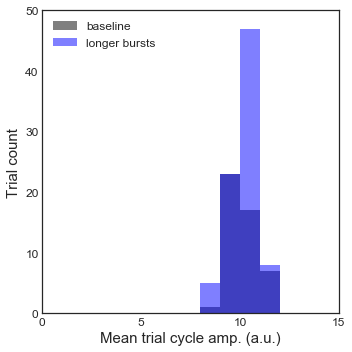

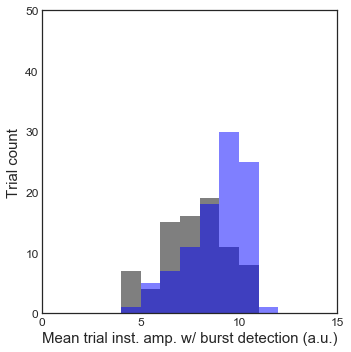

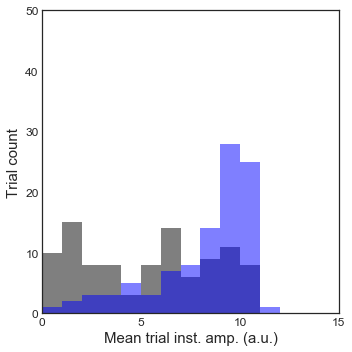

In [17]:
xmax = 15
ymax = 50
for name, sv, amp_means in zip(['cycle amp.', 'inst. amp. w/ burst detection', 'inst. amp.'],
                           ['cycle', 'inst_burst', 'inst'],
                           [cycle_amp_trial_means, burst_amp_mean, inst_amp_trial_means]):
    # Histogram of mean instantaneous amplitudes to see trial differentiation
    plt.figure(figsize=(5,5))
    colors = ['k', 'b']
    for i, c in enumerate(['baseline', 'longer bursts']):
        plt.hist(amp_means[c], bins=np.arange(0, xmax, 1), label=c, alpha=.5, color=colors[i])

    plt.xlim((0, xmax))
    plt.ylim((0, ymax))
    if sv == 'cycle':
        plt.legend(loc='best', fontsize=12)
    plt.ylabel('Trial count', size=15)
    plt.xlabel('Mean trial ' + name + ' (a.u.)', size=15)
    plt.xticks(np.arange(0, 20, 5), size=12)
    plt.yticks(np.arange(0, 60, 10), size=12)
    
    plt.tight_layout()
    plt.savefig('figs/5X_burst_duration_'+sv)